In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import pandas as pd
import seaborn as sns
import numpy as np
import gseapy as gp
import re
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette

def label_sample(x):
    if 'HS' in x:
        return 'High salt'
    elif 'Frag' in x:
        return 'Fragmented'
    elif re.search('N[aA]', x):
        return 'Alkaline hydrolysis'
    elif re.search('L[12]',x):
        return 'PolyA-selected'
    elif re.search('Exo|ED|DE', x):
        return 'Exonuclease I'
    elif 'All' in x:
        return 'Untreated'
    else:
        return 'Unfragmented'

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize =15)
plt.rc('ytick', labelsize = 15)
colors = okabeito_palette()
colors.append('black')

In [2]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
count_file = project_path + '/Counts/combined_gene_count.tsv'
#    .assign(grouped_type = lambda d: np.where(d.name.str.startswith('MT-'), 'MT', d.grouped_type))\


count_df = pd.read_table(count_file) \
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))
count_df.head()

,id,grouped_type,type,name,200FN_1_S3_R1_001,200FQ_1_S4_R1_001,200NDP_1_S5_R1_001,200ND_1_S6_R1_001,200ND_2_S7_R1_001,200NH_1_S8_R1_001,...,Qcf_HS3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_NA2_R1_001,Qcf_Na1_R1_001,S96_cfD_R1_001,S96_cf_R1_001,TEV1_R1_001,TEV2_R1_001,TEV3_R1_001
0,18S_rRNA,rRNA,rDNA,18S_rRNA,626746.5,795566.0,206622.5,70107.0,161960.5,150410.5,...,39709.5,1148.0,824.0,1031.0,1018.0,52527.5,56343.5,250282.0,0,2060.0
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1318143.5,1338619.0,523739.0,152026.5,350603.0,321675.5,...,85116.0,7031.5,9551.0,1996.5,2187.5,138170.5,147728.0,531806.0,0,2321.0
2,5.8S_rRNA,rRNA,rDNA,5.8S_rRNA,58194.5,55894.0,36639.5,92652.5,222217.5,171202.5,...,55162.5,192.0,96.0,122.0,160.0,181095.5,193164.5,500448.0,0,30.5
3,5S_rRNA,rRNA,rDNA,5S_rRNA,24427.5,81433.5,13364.5,11100.5,32791.5,27038.0,...,7250.0,133.5,37.5,58.0,85.5,1687.0,1783.0,18994.5,0,6.0
4,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,3.0,0.0,8.0,15.0,0.0,0.0,0.0,0,0.0


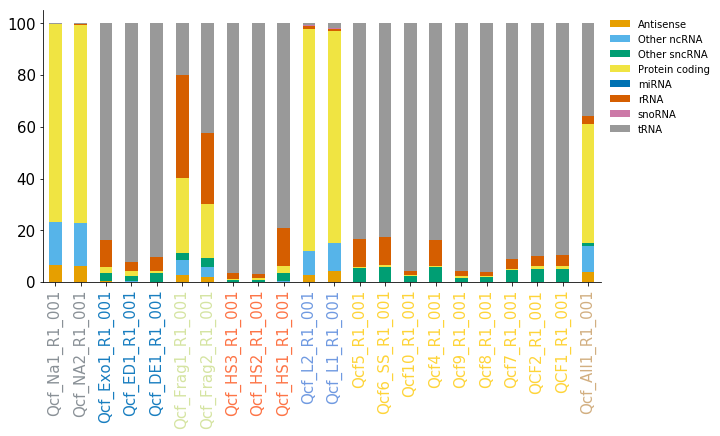

In [38]:
def percentage_columns(d):
    for col in d.columns:
        d[col] = d[col].transform(lambda x: 100*x/x.sum())
    return d

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
bar_df = count_df.drop(['id','type','name'], axis=1)\
    .filter(regex = 'grouped|Q[cC][fF]')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .assign(treatment = lambda d: d.index.map(label_sample))
    
bar_df.sort_values('treatment')\
    .drop('treatment', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)

ce = color_encoder()
ce.fit_transform(bar_df.treatment, simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
sns.despine()

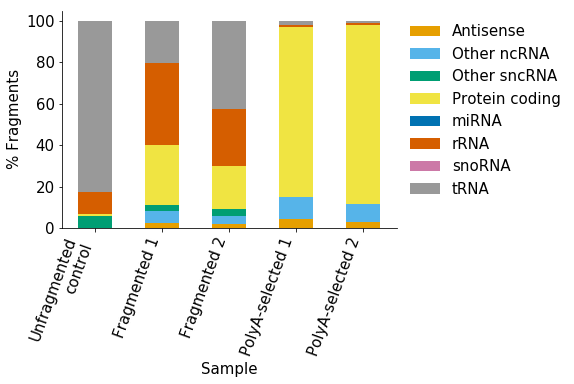

In [84]:
def rename_longRNA(name):
    try:
        x = name.split('_')[1]
        treatment = ''
    
        is_long = 0
        if 'Frag' in x:
            treatment = 'Fragmented'
            is_long = 1
        elif re.search('L[12]', x):
            treatment = 'PolyA-selected'
            is_long = 1
        elif re.search('Qcf[0-9]+|SS',name):
            treatment = 'Unfragmented\ncontrol'
            is_long = 0
    
        if is_long == 1:
            return treatment +' ' + re.search('\d+', x).group(0)
        else:
            return treatment 
    except IndexError:
        return name
        

fig = plt.figure()
ax = fig.add_subplot(111)
count_df\
    .filter(regex = 'grouped|L[12]|Frag|SS')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .rename(columns = rename_longRNA)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False, fontsize=15)
ax.set_xlabel('Sample')
ax.set_ylabel('% Fragments')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
sns.despine()

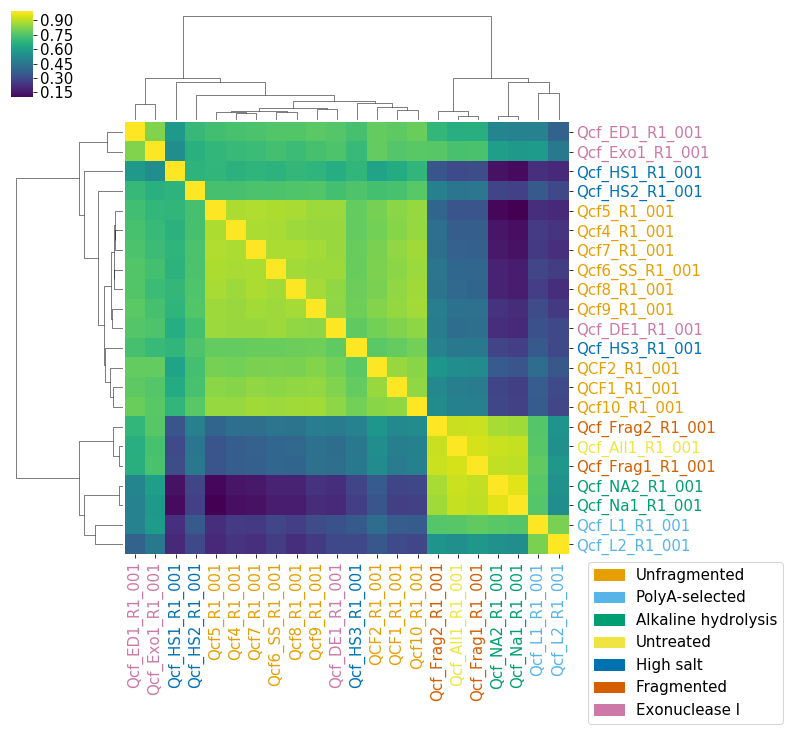

In [87]:
cor_df = np.log(count_df.filter(regex = 'Qcf|QCF')+1).corr()
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.map(label_sample), 
                 okabeito_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[label_sample(yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.5,0.), fontsize=15)

In [7]:
def count_to_tpm(count, length):
    rate = count/length
    tpm = rate/rate.sum() * 1e6 
    return tpm

gene_length = pd.read_table('/stor/work/Lambowitz/ref/hg19/genome/genes.length', 
                            names = ['id','glength'])
gene_length.head()

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .merge(gene_length)
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])
tpm_df.sort_values('Qcf_L1_R1_001', ascending=False).head()

,id,grouped_type,type,name,200FQ_1_S4_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
63097,MT-TH,tRNA,tRNA,MT-TH,80725.0,134870.061143,163881.336891,67111.763991,23402.791837,68
63110,MT-TV,tRNA,tRNA,MT-TV,54330.0,120993.669792,138297.853758,63261.300827,22235.035421,68
17059,ENSG00000188536,Protein coding,protein_coding,HBA2,880.0,33.723005,12.252762,43847.973864,79437.481397,863
63106,MT-TR,tRNA,tRNA,MT-TR,43506.0,70433.950985,102037.634794,42613.515141,14635.681809,64
18250,ENSG00000198712,Protein coding,protein_coding,MT-CO2,183.0,127.670624,69.804329,41613.318675,62815.085528,683


In [48]:
count_df\
    .query('type == "lincRNA"').sort_values('Qcf_L1_R1_001', ascending=False)\
    .head(20)

,id,grouped_type,type,name,200FN_1_S3_R1_001,200FQ_1_S4_R1_001,200NDP_1_S5_R1_001,200ND_1_S6_R1_001,200ND_2_S7_R1_001,200NH_1_S8_R1_001,...,Qcf_HS3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_NA2_R1_001,Qcf_Na1_R1_001,S96_cfD_R1_001,S96_cf_R1_001,TEV1_R1_001,TEV2_R1_001,TEV3_R1_001
31518,ENSG00000230021,Other ncRNA,lincRNA,RP5-857K21.4,106.0,2899.0,215.0,231.0,849.0,550.0,...,135.0,6085.0,9972.0,656.0,444.0,979.0,1030.0,22.0,0,99.0
33078,ENSG00000231918,Other ncRNA,lincRNA,AC007682.1,1.0,17.0,12.0,42.0,43.0,148.0,...,23.0,363.0,64.0,1165.0,1330.0,59.0,69.0,2.0,0,1.0
59982,ENSG00000269967,Other ncRNA,lincRNA,RP11-84A19.4,20.0,7.0,6.0,3.0,1.0,16.0,...,4.0,329.0,195.0,72.0,63.0,3.0,3.0,26.0,0,816.0
41992,ENSG00000248223,Other ncRNA,lincRNA,CTD-2139B15.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,326.0,462.0,0.0,1.0,0.0,0.0,0.0,0,255.0
41739,ENSG00000245832,Other ncRNA,lincRNA,RP11-179A16.1,0.0,23.0,6.0,23.0,30.0,96.0,...,10.0,247.0,171.0,747.0,955.0,58.0,64.0,3.0,0,112.0
61612,ENSG00000271860,Other ncRNA,lincRNA,RP11-436D23.1,2.0,9.0,5.0,4.0,6.0,63.0,...,6.0,187.0,21.0,470.0,590.0,25.0,30.0,0.0,0,0.0
44270,ENSG00000251574,Other ncRNA,lincRNA,RP11-6N13.1,7.0,23.0,11.0,9.0,16.0,73.0,...,9.0,183.0,45.0,800.0,927.0,53.0,64.0,20.0,0,16.0
44260,ENSG00000251562,Other ncRNA,lincRNA,MALAT1,15.0,98.0,10.0,39.0,50.0,41.0,...,0.0,182.0,353.0,9.0,11.0,64.0,69.0,960.0,0,9275.0
26738,ENSG00000224184,Other ncRNA,lincRNA,AC096559.1,1.0,7.0,5.0,17.0,10.0,100.0,...,8.0,169.0,11.0,854.0,1115.0,36.0,46.0,3.0,0,31.0
42833,ENSG00000249484,Other ncRNA,lincRNA,AC091969.1,0.0,17.0,6.0,9.0,11.0,65.0,...,1.0,164.0,27.0,634.0,732.0,28.0,38.0,3.0,0,1.0


In [8]:
tpm_df.query('type == "protein_coding"')\
    .query('Qcf_L1_R1_001 > 0.1 | Qcf_L2_R1_001 > 0.1')\
    .shape

(16825, 10)

In [9]:
gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
expr_df = pd.read_table(gene_expr)
expr_df.head()

,Gene,Gene name,Sample,Value,Unit
0,ENSG00000000003,TSPAN6,adipose tissue,31.5,TPM
1,ENSG00000000003,TSPAN6,adrenal gland,26.4,TPM
2,ENSG00000000003,TSPAN6,appendix,9.2,TPM
3,ENSG00000000003,TSPAN6,bone marrow,0.7,TPM
4,ENSG00000000003,TSPAN6,breast,53.4,TPM


In [10]:
top_n = 80
tpm_cor_df = tpm_df.filter(regex='id|Qcf')\
    .rename(columns = {'id':'Gene'})
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene'], values='Value') \
    .reset_index() \
    .merge(tpm_cor_df, on ='Gene', how ='inner')\
    .iloc[:, 1:]\
    .corr(method = 'spearman')\
    .filter(regex = 'Qcf|Frag') \
    .reset_index() \
    .pipe(lambda d: d[~d['index'].str.contains('Qcf')])\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .head(top_n)
cor_df.index = cor_df['index']
cor_df.head()

,index,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
index,,,,,
bone marrow,bone marrow,0.023409,0.073079,0.474150,0.552667
lymph node,lymph node,0.020637,0.069937,0.473638,0.548867
spleen,spleen,0.044183,0.088051,0.471368,0.547290
appendix,appendix,0.041150,0.090673,0.461598,0.532582
tonsil,tonsil,0.004952,0.061589,0.456367,0.521787


Text(1,0.6,"Spearman's $\\rho$")

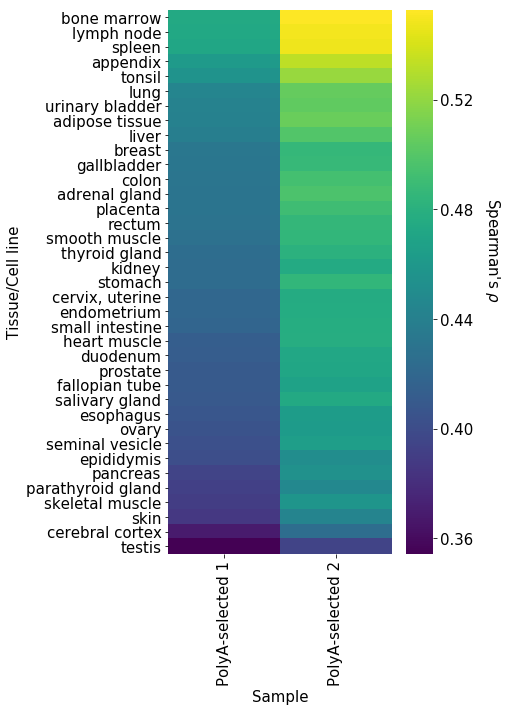

In [11]:
fig = plt.figure(figsize = (5,10))
ax = fig.add_subplot(111)
sns.heatmap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
           cmap = 'viridis', ax = ax)
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line')
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=15)
fig.text(1,0.6, r"Spearman's $\rho$", rotation = 270, fontsize=15)

Text(0.08,0.85,"Spearman's $\\rho$")

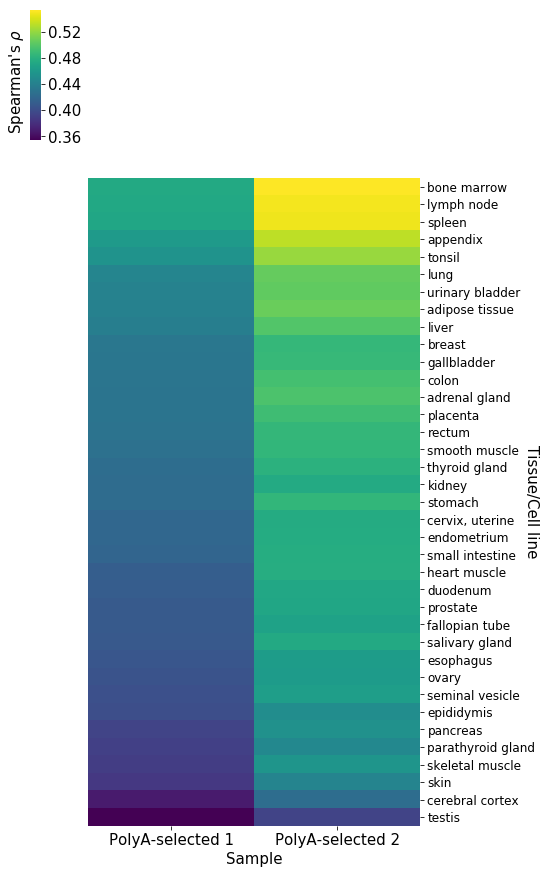

In [12]:
p = sns.clustermap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
                row_cluster=False,
                col_cluster=False,
               cmap = 'viridis',
               figsize = (7,15))
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=12)#[p.dendrogram_row.reordered_ind])
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line', rotation=270)
p.fig.text(0.08,0.85, r"Spearman's $\rho$", rotation = 90, fontsize=15)

In [13]:
tpm_df.head()

,id,grouped_type,type,name,200FQ_1_S4_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
0,18S_rRNA,rRNA,rDNA,18S_rRNA,795566.0,24029.830532,11232.077953,1078.787483,714.086298,1870
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1338619.0,14810.565013,6310.127943,2454.541544,3074.685703,5034
2,5.8S_rRNA,rRNA,rDNA,5.8S_rRNA,55894.0,34382.527162,14474.772265,2162.779515,997.267645,156
3,5S_rRNA,rRNA,rDNA,5S_rRNA,81433.5,29977.414367,15400.321106,1954.949921,506.424976,120
4,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.106709,0.020483,0.465663,0.000000,11321


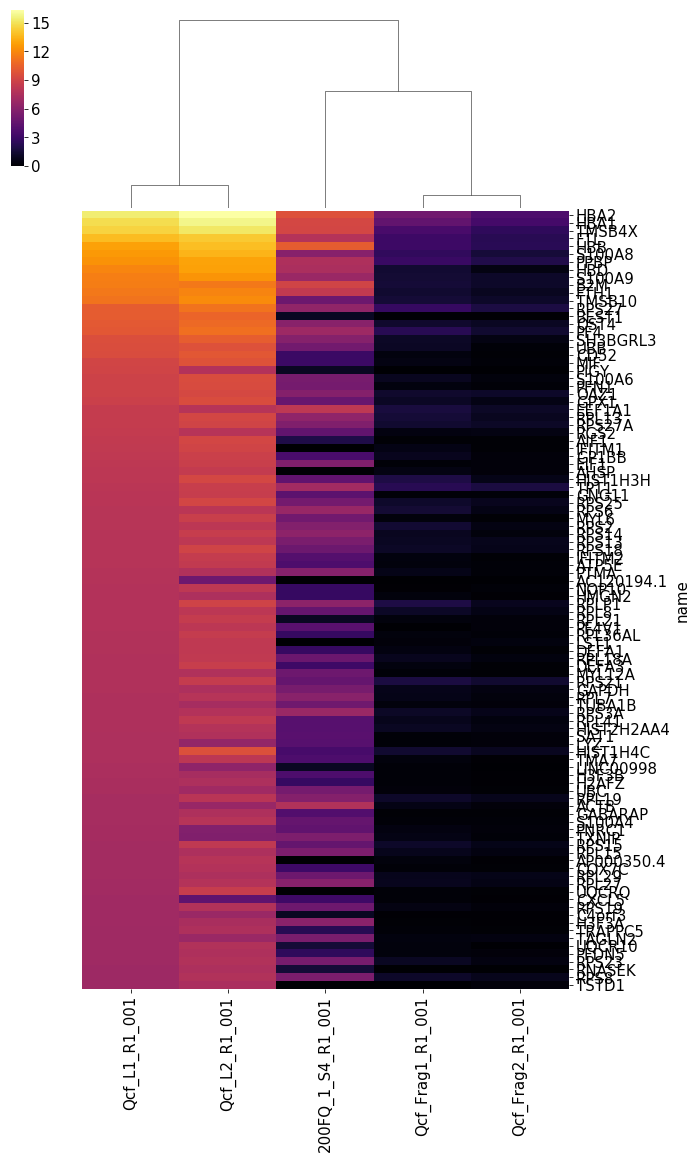

In [14]:
top_n = 100
hd = tpm_df\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .query('type == "protein_coding"')\
    .pipe(lambda d: d[~d.name.str.contains('^MT')])
hd.index = hd.name

p = sns.clustermap(np.log2(hd\
                           .head(top_n)\
                           .filter(regex = 'Q')+1),
              row_cluster=False,
              cmap='inferno',
              figsize = (10,18))
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(top_n) +0.5)
yt = ax.set_yticklabels(hd.index[:top_n])

In [15]:
samplename = 'Qcf_L1_R1_001'

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .merge(gene_length) \
    .query('type == "protein_coding"')
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])
tpm_df.sort_values('Qcf_L1_R1_001', ascending=False).head()


rank_df = expr_df\
    .pipe(lambda d: d[np.in1d(d.Sample, ['bone marrow', 'lymph node', 'spleen'])])\
    .rename(columns = {'Gene':'id',
                       'Gene name':'name'})\
    .groupby(['id','name'], as_index=False)\
    .agg({'Value':'mean'})\
    .filter(['id','name','Value'])\
    .merge(hd\
            .loc[:,['id','name',samplename]],
          on = ['id','name']) \
    .assign(rank = lambda d: d[samplename].rank() - d['Value'].rank()) \
    .sort_values('rank', ascending=False)
rank_df.head(20)

,id,name,Value,Qcf_L1_R1_001,rank
17945,ENSG00000255072,PIGY,0.0,528.804598,17214.0
18226,ENSG00000267697,LUZP6,0.0,69.890957,17076.0
13936,ENSG00000180389,ATP5EP2,0.0,68.642905,17072.5
16906,ENSG00000206106,KRTAP22-2,0.0,24.072032,16817.0
15789,ENSG00000196578,OR5AC2,0.0,11.349354,16492.0
16186,ENSG00000198128,OR2L3,0.0,11.240459,16488.0
17268,ENSG00000221864,KRTAP12-2,0.0,9.524436,16381.0
17528,ENSG00000236032,OR5H14,0.0,8.142995,16271.0
17987,ENSG00000256100,AP000721.4,0.0,7.937492,16246.0
14482,ENSG00000183706,OR4N4,0.0,7.810037,16235.0


In [16]:
rankings = pd.concat([rank_df.head(500), rank_df.tail(500)])

In [17]:
enriched = gp.prerank(rnk=rankings.loc[:,['name','rank']],
           gene_sets='KEGG_2016')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


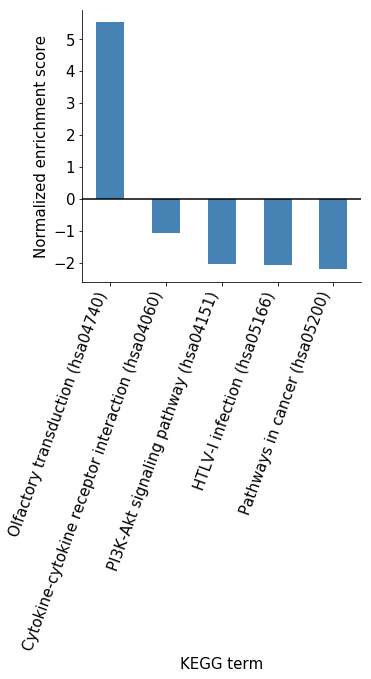

In [18]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
enriched\
        .res2d\
        .reset_index()\
        .assign(log_fdr = lambda d: d.pval.transform(lambda x: -np.log(x or 0.00001)))\
        .sort_values('nes', ascending=False)\
        .assign(Term = lambda d: d.Term.str.replace('_Homo sapiens_',' (') + ')')\
        .plot\
        .bar('Term', 'nes', color = 'steelblue', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.hlines(y = 0, xmin=-1, xmax=1000)
ax.set_ylabel('Normalized enrichment score')
ax.set_xlabel('KEGG term')
ax.legend().set_visible(False)
sns.despine()

In [19]:
enriched.res2d.sort_values('pval')

,es,nes,pval,fdr,gene_set_size,matched_size,genes
Term,,,,,,,
Olfactory transduction_Homo sapiens_hsa04740,0.771941,5.515591,0.000000,0.000000,415,43,"OR5AC2,OR2L3,OR5H14,OR4N4,OR2A12,OR56A1,OR2M3,..."
Pathways in cancer_Homo sapiens_hsa05200,-0.385729,-2.217798,0.000000,0.000000,397,25,"BIRC8,FZD9,FGF6,FGF21,FH,LAMB1,COL4A2,CTNNB1,I..."
PI3K-Akt signaling pathway_Homo sapiens_hsa04151,-0.367399,-2.048101,0.002169,0.005215,341,23,"IFNA5,IFNA21,FGF6,FGF21,LAMB1,COL4A2,IL7R,TSC2..."
HTLV-I infection_Homo sapiens_hsa05166,-0.390602,-2.087669,0.004386,0.007823,258,21,"FZD9,CSF2,MSX1,PPP3R1,HLA-DOB,ATF3,CTNNB1,RANB..."
Cytokine-cytokine receptor interaction_Homo sapiens_hsa04060,-0.205861,-1.082579,0.333333,0.345502,265,21,"IFNA5,IFNA21,IL20,IL25,IL20RA,CSF2,PF4V1,IL26,..."


In [20]:
rnk = enriched
def find_pathway(keyword):
    return [k for k in rnk.results.keys() if keyword in k]

def find_gene(rnk, genes):
    return [i for i, g in enumerate(rnk.rnk.name) if g in genes]

def plot_enrichment(kegg_key):
    assert(kegg_key.startswith('hsa'))
    pathway = find_pathway(kegg_key)[0]
    rnk_dict = rnk.results[pathway]
    genes = rnk_dict['genes']
    res = rnk_dict['rank_ES']

    fig = plt.figure(figsize = (8,8))
    es_ax = fig.add_axes([0, 0.5, 1, 0.5])
    gene_ax = fig.add_axes([0,0.45, 1, 0.049])
    heat_ax = fig.add_axes([0, 0.2, 1, 0.45])
    cor_ax = fig.add_axes([0, 0, 1, 0.4])

    xlims = len(res)

    # enrichment plot
    es_ax.plot(res, linewidth=4, color = 'steelblue')
    es_ax.hlines(xmin = -100, xmax = xlims, y = 0, color = 'black')
    es_ax.set_xlim(0, xlims)
    es_ax.xaxis.set_visible(False)
    es_ax.set_ylabel('Running\nEnrichment\nscore')

    # gene plot
    gene_ax.vlines(ymin = 0, ymax = 1, 
               x = find_gene(rnk, genes), 
               color = 'steelblue')
    gene_ax.set_xlim(0, xlims)
    gene_ax.set_yticklabels([])
    gene_ax.xaxis.set_visible(False)
    gene_ax.text(-50, 0.15,'Pathway\ngene', size = 15, ha = 'right')

    # heat cor
    im = heat_ax.imshow([rnk.ranking.values] * 100, cmap = 'viridis')
    heat_ax.xaxis.set_visible(False)
    heat_ax.yaxis.set_visible(False)

    # cor plot
    cor_ax.plot(rnk.ranking.values, 
            color = 'steelblue')
    cor_ax.fill_between(np.arange(0, xlims), 0, rnk.ranking.values)
    cor_ax.hlines(xmin = -100, xmax = xlims, y = 0, color = 'black')
    cor_ax.set_xlim(0, xlims)
    cor_ax.set_ylabel('Gene rank difference between\nplasma and average of \nbone marrow, lymph node, and spleen')
    cor_ax.set_xlabel('Gene')
    cor_ax.spines['top'].set_visible(False)

    fig.text(0.5, 1.02, pathway.replace('_Homo sapiens_','\n'), size = 20, ha='center')
    
    figurename = '../figures/' + kegg_key + '.png'
    #fig.savefig(figurename, bbox_inches='tight', transparent = True)
    print('Plotted %s' %figurename)

Plotted ../figures/hsa04740.png


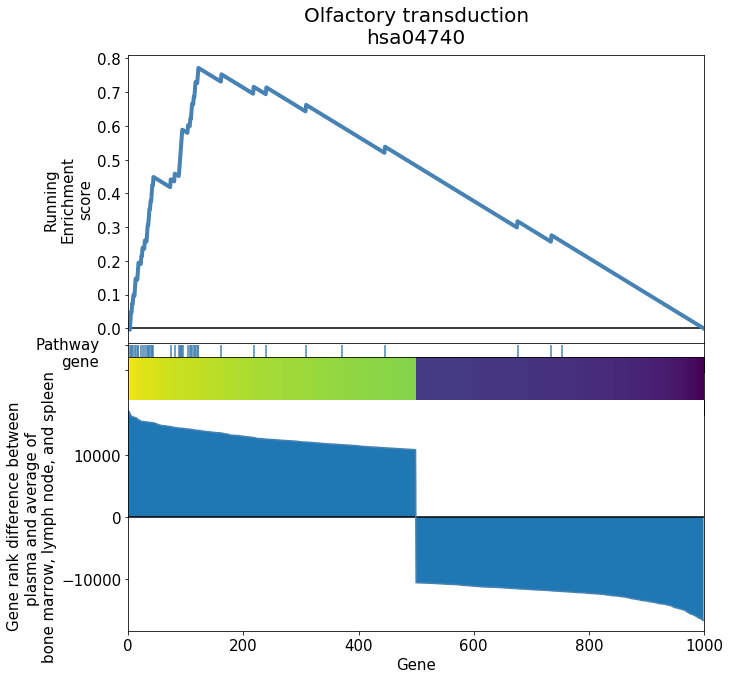

In [21]:
plot_enrichment('hsa04740')

Plotted ../figures/hsa04151.png


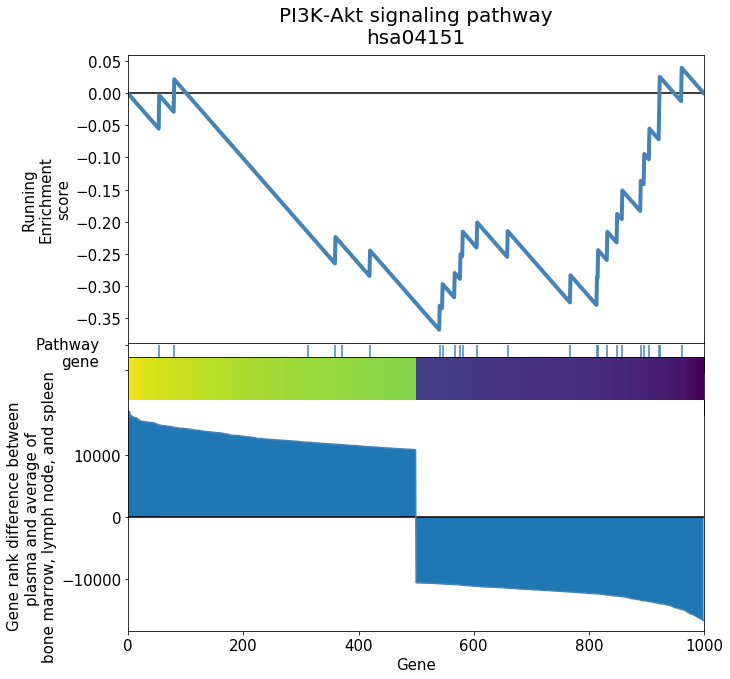

In [22]:
plot_enrichment('hsa04151')

In [23]:
rnk.results['Olfactory transduction_Homo sapiens_hsa04740']['genes']

'OR5AC2,OR2L3,OR5H14,OR4N4,OR2A12,OR56A1,OR2M3,OR7C1,OR4X1,OR8H3,OR5K3,OR5M11,OR10AG1,OR2W1,OR4C3,OR4C11,OR6C1,OR52B2,OR8K1,OR10C1,OR2B6,OR6C70,OR2M5,OR8H2,OR10Z1,OR5H1,OR10G7,OR1G1,OR2A5,OR13G1,OR2T4,OR5P2,OR4A16,OR10G2,OR5H6,OR2F2,OR2T33,OR4N2,OR11A1,OR3A2,OR7A5,PDE2A,PRKACA'

Plotted ../figures/hsa05200.png


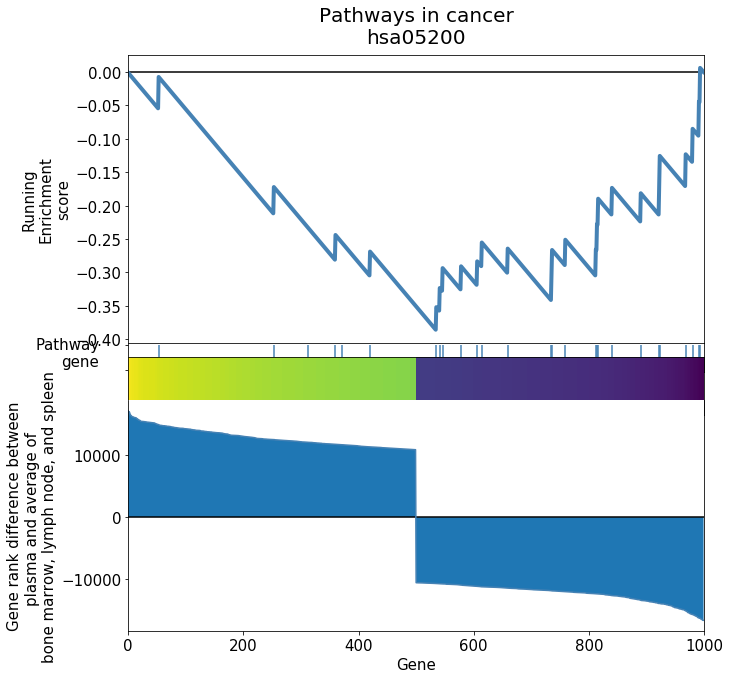

In [24]:
plot_enrichment('hsa05200')

In [25]:
rnk.results['Pathways in cancer_Homo sapiens_hsa05200']['genes']

'BIRC8,FZD9,FGF6,FGF21,FH,LAMB1,COL4A2,CTNNB1,IL6,DVL2,JAK1,PRKACA,STK4,TRAF4,CRKL,LAMB2,CDK2,HIF1A,LPAR2,IKBKG,NRAS,NFKB2,RASSF5,MMP9,NCOA4'

In [26]:
rank_df.sort_values('Qcf_L1_R1_001', ascending = False)

,id,name,Value,Qcf_L1_R1_001,rank
15459,ENSG00000188536,HBA2,6268.566667,43847.973864,7.0
16910,ENSG00000206172,HBA1,5809.766667,29743.997737,8.0
16834,ENSG00000205542,TMSB4X,9251.033333,23132.950377,1.0
1667,ENSG00000087086,FTL,3950.900000,13999.008707,11.0
17772,ENSG00000244734,HBB,26265.600000,7589.156732,-4.0
8095,ENSG00000143546,S100A8,5240.666667,6284.174779,5.0
10638,ENSG00000163736,PPBP,44.966667,5296.034028,1912.0
17326,ENSG00000223609,HBD,407.966667,3847.429700,154.0
10482,ENSG00000163220,S100A9,7406.133333,3230.409074,-2.0
11390,ENSG00000166710,B2M,3201.133333,3081.851209,9.0


In [27]:
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene', 'Gene name'], values='Value') \
    .reset_index() \
    .pipe(lambda d: d[~d['Gene name'].str.contains('^MT')])\
    .merge(tpm_cor_df.rename(columns=rename_longRNA), on ='Gene', how ='inner') \
    .sort_values('PolyA-selected 1', ascending=False)
cor_df.index= cor_df['Gene name']
cor_df.head(10)

,Gene,Gene name,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,...,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,Fragmented 1,Fragmented 2,PolyA-selected 1,PolyA-selected 2
Gene name,,,,,,,,,,,,,,,,,,,,,
HBA2,ENSG00000188536,HBA2,226.0,336.7,218.0,18369.0,213.0,59.0,73.2,78.2,...,427.2,32.4,13.3,55.4,8.2,28.5,33.723005,12.252762,43847.973864,79437.481397
HBA1,ENSG00000206172,HBA1,142.9,233.6,143.1,17119.3,110.9,48.3,34.8,58.1,...,303.5,20.4,9.4,35.4,3.9,17.1,22.042751,9.584007,29743.997737,57141.096876
TMSB4X,ENSG00000205542,TMSB4X,3805.9,5439.9,6688.8,5468.2,3675.2,2891.0,4421.5,4173.9,...,10744.7,4224.3,928.3,1529.5,6487.7,5915.7,10.313672,4.924493,23132.950377,38280.087972
FTL,ENSG00000087086,FTL,4755.5,2291.2,3208.8,2600.5,2719.6,1997.8,2925.6,2081.9,...,5838.2,1280.3,889.4,2427.0,1209.1,3753.2,7.312212,3.970197,13999.008707,18639.008176
HBB,ENSG00000244734,HBB,627.5,654.3,306.3,78046.6,854.1,85.0,283.8,266.8,...,720.7,48.9,30.1,456.2,37.1,180.5,7.431385,4.188276,7589.156732,14481.976483
S100A8,ENSG00000143546,S100A8,464.5,22.0,1232.5,14915.7,36.9,11.7,176.7,25.4,...,786.1,10.9,13.0,12.6,4867.3,166.9,5.225117,2.086198,6284.174779,11527.564231
PPBP,ENSG00000163736,PPBP,2.3,1.4,1.6,110.6,1.1,0.5,0.1,0.2,...,24.3,0.1,0.0,1.6,0.0,0.7,6.917204,3.121196,5296.034028,8010.515791
HBD,ENSG00000223609,HBD,0.1,0.3,0.7,1221.3,0.0,0.0,0.0,0.4,...,2.2,0.2,0.1,0.1,0.1,0.1,1.754222,0.430700,3847.429700,7591.107220
S100A9,ENSG00000163220,S100A9,794.0,53.5,2087.4,20959.3,51.3,20.9,255.9,42.7,...,1188.6,17.2,16.6,29.3,3911.6,1006.1,1.869024,1.257009,3230.409074,5486.307816


Text(0.1,0.85,'TPM ($log_2$)')

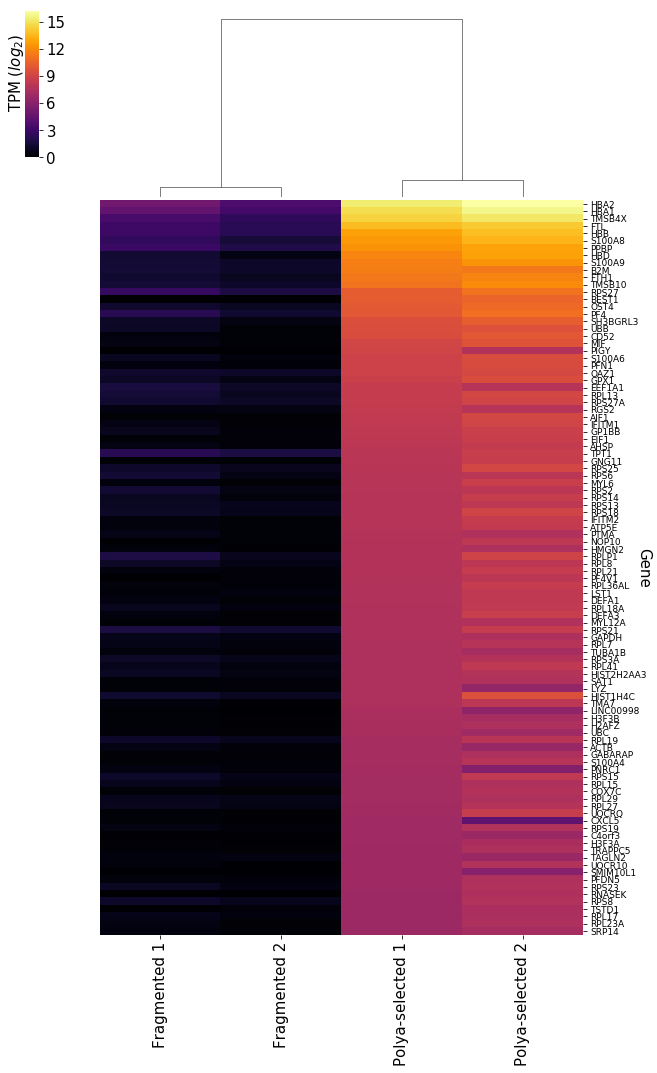

In [28]:
top_n = 100
p = sns.clustermap(np.log2(cor_df.iloc[:top_n,-4:]+1),
                   row_cluster=False,
                  figsize = (10,17),
                  cmap = 'inferno')
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(top_n)+0.5)
xt = ax.set_xticks(np.arange(4) + 0.5)
xt = ax.set_xticklabels(cor_df.columns[-4:].str.capitalize()[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 270)
p.fig.text(0.1,0.85, r'TPM ($log_2$)', rotation = 90, fontsize=15)

Text(0.1,0.85,'TPM ($log_2$)')

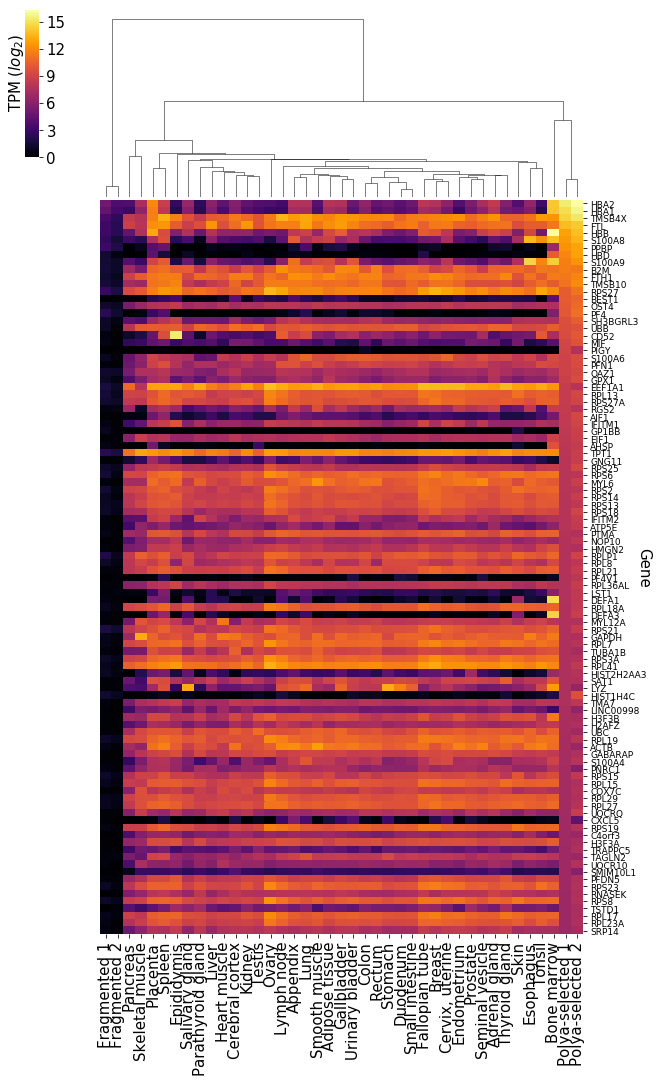

In [29]:
top_n = 100
p = sns.clustermap(np.log2(cor_df.iloc[:top_n,2:]+1),
                   row_cluster=False,
                  figsize = (10,17),
                  cmap = 'inferno')
ax = p.ax_heatmap
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(cor_df.shape[1] - 2) + 0.5)
xt = ax.set_xticklabels(cor_df.columns[2:].str.capitalize()[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 270)
p.fig.text(0.1,0.85, r'TPM ($log_2$)', rotation = 90, fontsize=15)

Text(0.9,0.5,'TPM ($log_2$)')

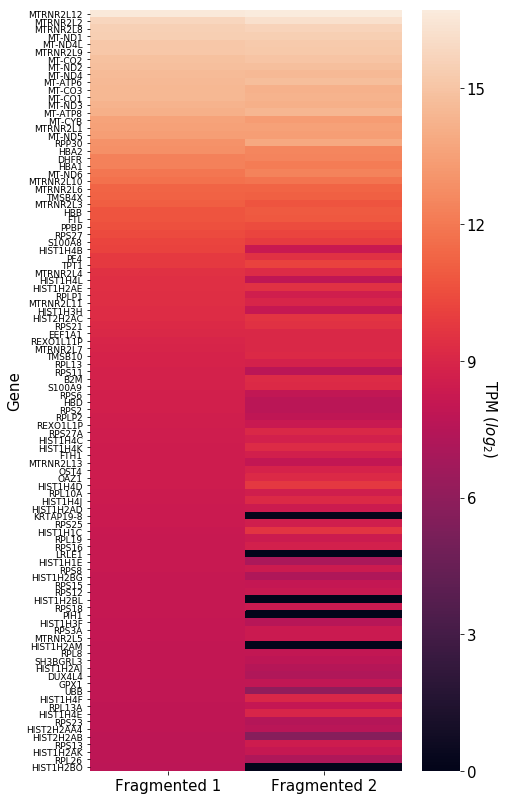

In [30]:
fig = plt.figure(figsize=(7,14))
ax = plt.subplot(111)
frag_df = tpm_df\
    .filter(regex='id|name|type|Frag')\
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .set_index('name')
p = sns.heatmap(np.log2(frag_df.iloc[:top_n,-2:]+1), ax =ax)
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(2) + 0.5)
xt = ax.set_xticklabels(frag_df.columns[-2:].map(rename_longRNA))
yt = ax.set_yticklabels(frag_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 90)
fig.text(0.9,0.5, r'TPM ($log_2$)', rotation = 270, fontsize=15)

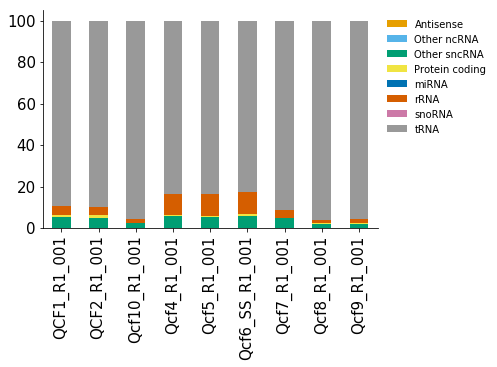

In [31]:
ax = plt.subplot(111)
count_df.filter(regex='grou|Q[cC][Ff][0-9]+')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)
sns.despine()

In [32]:
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')
dedup_df.head()

,gene_id,gene_name,gene_type,grouped_type,200FN_1_S3_R1_001:all:antisense,200FN_1_S3_R1_001:all:sense,200FN_1_S3_R1_001:dedup:antisense,200FN_1_S3_R1_001:dedup:sense,200FQ_1_S4_R1_001:all:antisense,200FQ_1_S4_R1_001:all:sense,...,Qcf_Na1_R1_001:dedup:antisense,Qcf_Na1_R1_001:dedup:sense,S96-cfD_R1_001:all:antisense,S96-cfD_R1_001:all:sense,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense
0,18S_rRNA,18S_rRNA,rDNA,rDNA,1789,1253493,1408,867335,2500,1591132,...,901,1880,575,105388,359,46970,945,113126,583,48893
1,28S_rRNA,28S_rRNA,rDNA,rDNA,1795,2636287,1447,1692392,2133,2677238,...,1422,4006,1006,277376,597,109543,1340,296715,787,113377
2,5.8S_rRNA,5.8S_rRNA,rDNA,rDNA,135,116389,110,44882,127,111788,...,101,294,67,362407,32,15992,74,386566,34,16284
3,5S_rRNA,5S_rRNA,rDNA,rDNA,27,48855,21,18586,79,162867,...,65,157,6,3413,5,1355,6,3607,5,1393
4,Alu,SINE:AluJb,Repeats,Repeats,197,209,169,169,403,787,...,39517,47502,3022,2676,1727,1418,3315,3042,1865,1632


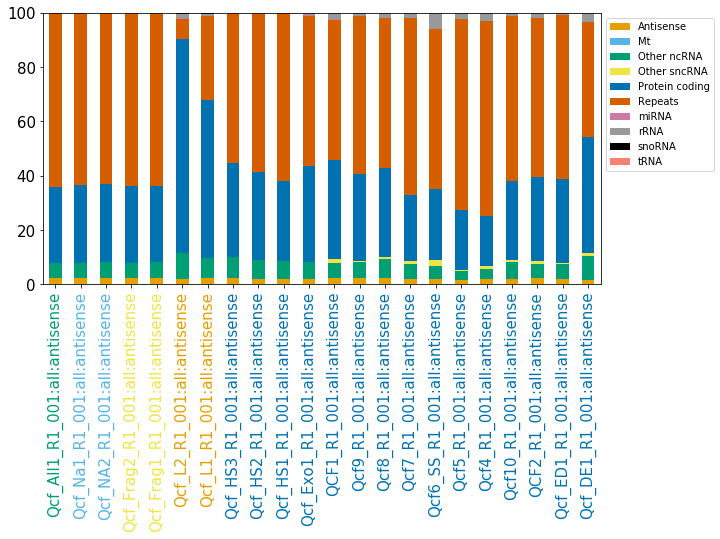

In [35]:
from tgirt_map.table_tool import change_gene_type
from sequencing_tools.viz_tools import color_encoder, simpsons_palette

def label_treatment(x, return_label=False):
    if 'All' in x:
        return 'Total nucleic acid' if return_label else 1
    elif re.search('NA|Na', x):
        return 'Alkaline hydrolysis' if return_label else 2
    elif re.search('Frag|frag', x):
        return 'Fragmented' if return_label else 3
    elif re.search('L[12]', x):
        return 'PolyA-selected' if return_label else 4
    else:
        return 'DNase-treatment' if return_label else 5

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
colors.append('salmon')
dedup_df\
    .assign(gene_type = lambda d: d.gene_type.map(change_gene_type))\
    .filter(regex = 'type|Qcf|QCF')\
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
    .groupby('grouped_type')\
    .sum() \
    .pipe(lambda d: d[d.columns[d.columns.str.contains('anti')]])\
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('dedup')]])\
    .pipe(percentage_columns)\
    .transpose() \
    .assign(prep = lambda d: d.index.map(label_treatment))\
    .sort_values('prep')\
    .drop('prep', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1))

preps = [label_treatment(_.get_text(), return_label=True) for _ in ax.get_xmajorticklabels()]
ce = color_encoder()
ce.fit(preps)
for _, pre in zip(ax.get_xmajorticklabels(),preps):
    _.set_color(ce.encoder[pre])

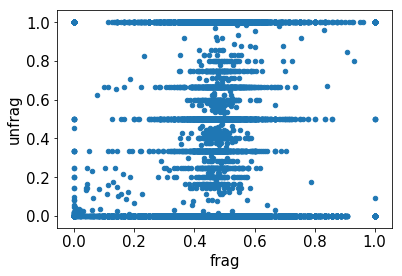

In [77]:
def frac(x, y):
    return x/(x+y)

sense_df = dedup_df\
    .filter(regex = 'Frag1.*dedup|QCF1_.*dedup|type|name|id')  \
    .assign(frag = lambda d: frac(d['Qcf_Frag1_R1_001:dedup:antisense'], d['Qcf_Frag1_R1_001:dedup:sense'])) \
    .assign(unfrag = lambda d: frac(d['QCF1_R1_001:dedup:antisense'],d['QCF1_R1_001:dedup:sense']))  \
    .query('grouped_type != "Repeats"') \
    .replace([np.inf, -np.inf], np.nan)\
    .fillna(0)
sense_df.plot.scatter('frag','unfrag')

In [80]:
sense_df.query('frag > unfrag').sort_values('frag', ascending=False).pipe(lambda d: d[d['QCF1_R1_001:dedup:antisense']>10])

,gene_id,gene_name,gene_type,grouped_type,QCF1_R1_001:dedup:antisense,QCF1_R1_001:dedup:sense,Qcf_Frag1_R1_001:dedup:antisense,Qcf_Frag1_R1_001:dedup:sense,frag,unfrag
12470,ENSG00000167995,BEST1,protein_coding,Protein coding,11,2,59,6,0.907692,0.846154
3117,ENSG00000104904,OAZ1,protein_coding,Protein coding,209,103,196,37,0.841202,0.669872
30271,ENSG00000230021,RP5-857K21.4,lincRNA,Other ncRNA,157,741,1254,338,0.787688,0.174833
27963,ENSG00000226745,RP11-115D7.3,pseudogene,Other ncRNA,12,9,4,2,0.666667,0.571429
18298,ENSG00000198727,MT-CYB,protein_coding,Protein coding,12,39,226,488,0.316527,0.235294
0,18S_rRNA,18S_rRNA,rDNA,rDNA,208,85491,1858,663189,0.002794,0.002427
1,28S_rRNA,28S_rRNA,rDNA,rDNA,299,175916,1808,1063269,0.001698,0.001697
42394,ENSG00000252316,RNY4,misc_RNA,Other sncRNA,65,76826,16,14547,0.001099,0.000845


In [82]:
expr_df.query('Sample == "bone marrow"').sort_values('Value', ascending=False). head(20)

,Gene,Gene name,Sample,Value,Unit
684947,ENSG00000244734,HBB,bone marrow,78046.6,TPM
678176,ENSG00000240247,DEFA1B,bone marrow,46364.0,TPM
647022,ENSG00000206047,DEFA1,bone marrow,30312.0,TPM
677584,ENSG00000239839,DEFA3,bone marrow,23273.5,TPM
398974,ENSG00000163220,S100A9,bone marrow,20959.3,TPM
590375,ENSG00000188536,HBA2,bone marrow,18369.0,TPM
647651,ENSG00000206172,HBA1,bone marrow,17119.3,TPM
307584,ENSG00000143546,S100A8,bone marrow,14915.7,TPM
628781,ENSG00000198938,MT-CO3,bone marrow,7203.4,TPM
625895,ENSG00000198804,MT-CO1,bone marrow,6962.5,TPM
